### Required Files and Directories

#### Before Running the Notebook
1. **Demographic and Polysomnographic Data**:
   - `chat-baseline-dataset-0.12.0.csv`: Baseline demographic and polysomnographic data, including AHI.
   - `chat-followup-dataset-0.12.0.csv`: Follow-up demographic and polysomnographic data, including AHI.

2. **XML Folder (Annotations)**:
   - `XML/baseline/`: Baseline group XML annotation files for event data.
   - `XML/followup/`: Follow-up group XML annotation files for event data.

#### Created After Running the Notebook
1. **CSV Folder (Processed Data)**:
   - `CSV/ap_ends/`: CSV files with apnea event end times for each signal.
   - `CSV/od_nadirs/`: CSV files with oxygen desaturation nadir times for each signal.
   - `CSV/od_starts/`: CSV files with oxygen desaturation start times for each signal.

2. **Processed Data Folder**:
   - `processed_data/AHI.npy`: AHI values for each subject.
   - `processed_data/IDs.npy`: Unique subject IDs.
   - `processed_data/data.npy`: 20-minute SpO₂ signal segments with subject indices.

**Note**: The same subject IDs can appear in both the Baseline and Follow-up groups, but their subject index will be different. This ensures proper management of segments belonging to the same subjectand avoid mislabeling.

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Installation

In [ ]:
!pip install pyEDFlib -q
!pip install xmltodict -q
!pip install mne -q

# Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy import signal
from tqdm import tqdm
import glob
import os
import xml.etree.ElementTree as ET
import xmltodict
import pyedflib
import scipy.signal as signal
import mne
import requests
from bs4 import BeautifulSoup
import mne
import warnings

# Functions

In [ ]:
def Extract_page_edf_IDs(group, page_number):
  res = requests.get(f"https://sleepdata.org/datasets/chat/files/polysomnography/edfs/{group}?page={page_number}")
  soup = BeautifulSoup(res.text, "html.parser")
  # Find all <td> elements and filter those with .edf files
  edf_files_IDs = []
  for td in soup.find_all("td"):
      if ".edf" in td.text:
        edf_files_IDs.append(td.text.strip().split(".")[0].split("-")[-1])

  print("edf_files_IDs: ", edf_files_IDs)
  return edf_files_IDs

# Downloading Instructions

In [ ]:
#################

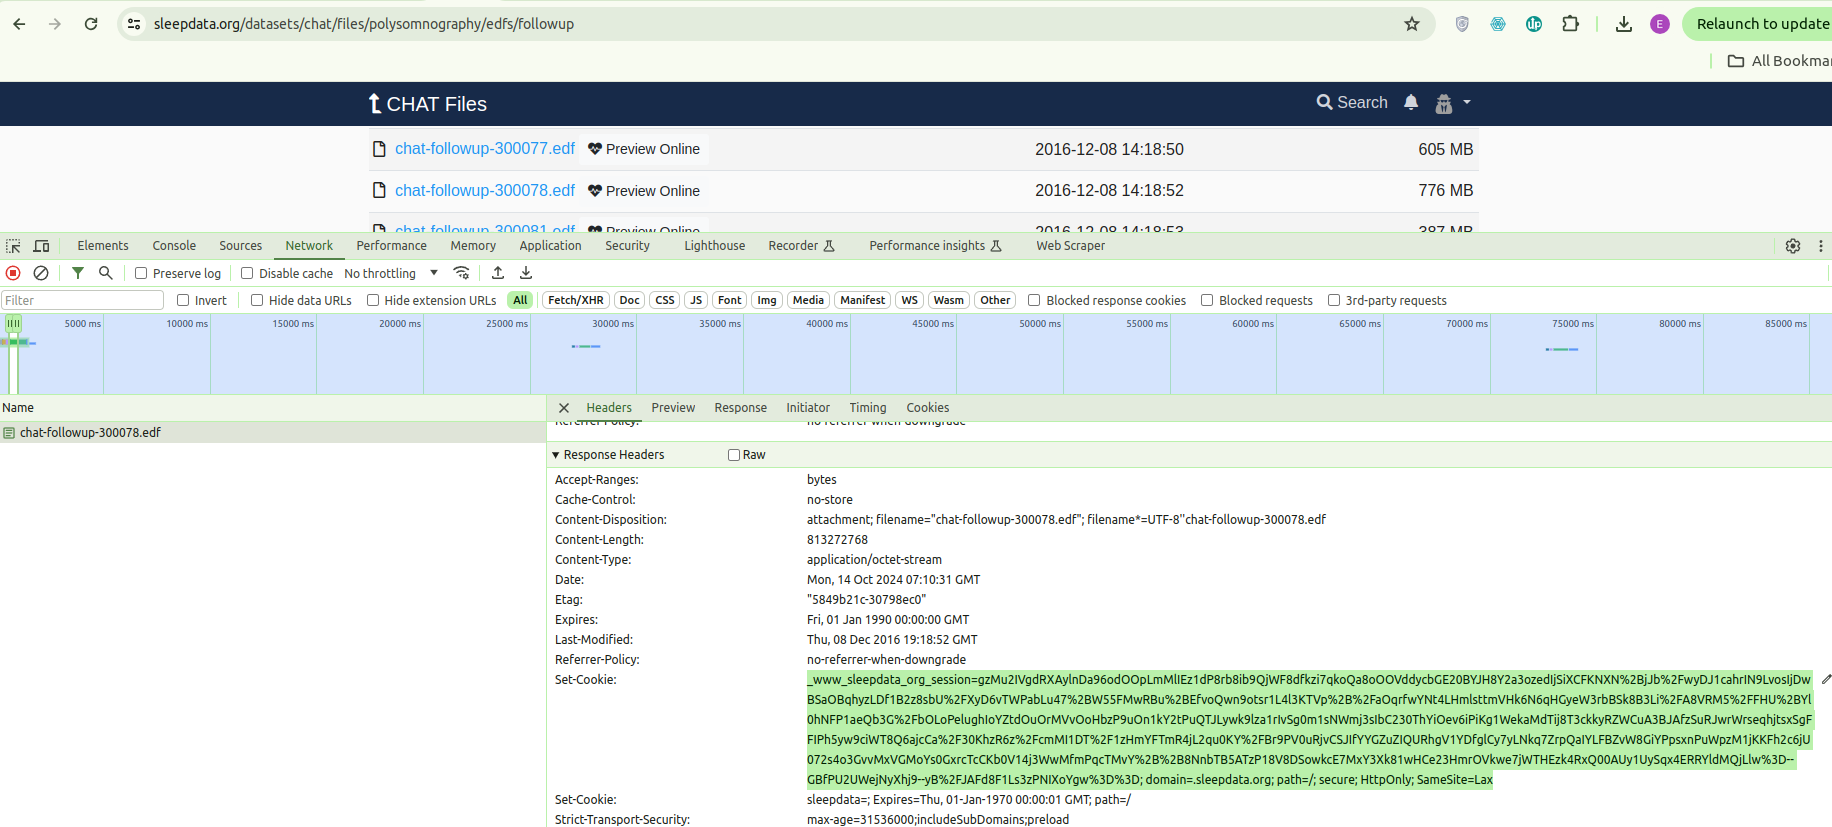

---

**Instructions for Retrieving the Cookie:**

1. First, log in to your account at [sleepdata.org](https://www.sleepdata.org).
2. Navigate to either:
   - [Baseline EDF files](https://www.sleepdata.org/datasets/chat/files/polysomnography/edfs/baseline)
   - [Followup EDF files](https://www.sleepdata.org/datasets/chat/files/polysomnography/edfs/followup)
3. Open your browser's developer tools (Inspect) and click on the link to one of the `.edf` files. When the download begins automatically, cancel it.
4. In the developer tools, go to the **Network** tab and select **All**.
5. In the **Name** column, click on the `.edf` file name. This will open the **Headers** tab.
6. Search for the field labeled **"Set-Cookie:"**. Copy the value of this cookie.
7. Paste the copied cookie into the `headers` dictionary under the `"Cookie"` field in the function below.

---

In [ ]:
def Download_edf_files(group, edf_files_IDs):
  for id in edf_files_IDs:
    # url = "https://www.sleepdata.org/datasets/chat/files/m/browser/polysomnography/edfs/followup/chat-followup-{}.edf"
    headers = {
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
        "Accept-Encoding": "gzip, deflate, br",
        "Accept-Language": "en-US,en-GB;q=0.9,en;q=0.8",
        "Connection": "keep-alive",
        "Cookie": "_www_sleepdata_org_session=PCe1oljnhgkRiwDuYH9EL9fM3xqA5JsBFKAejRdwu5Bh3AotyL5PBSZriH6x2nIoWShRxFZGjiLexEvsUbtFLieQBu5M03eyL0m21ejb5rs0Ag2W1zT%2F67EOkRtxuk5INfyNGPeB4lrcSr5ep1385nhwmzL1L%2BfKGuUSTnuWGxcBw7c%2FR7g%2BIlcdP3ZOxDI3BavRU0gRAdR1zBacqILXyY1zufbxv3sC%2BNHPxbjqzg10Na8mdV%2BnumitHgRcRkwYFFZJSPdayHGUQDhtaDt%2F2jl9GHVWfHlejAcAbUKXha%2F1MRaGwzdH%2BuS5%2BG8RF0586ZPcQvlSku7xfLMBPk3cpKhBxVNuIy8g7LheDpY8V%2BnLm4GCYfV%2BjVeaD8VYhn2nyT6g6Z2zfzID1Dr%2B48v3vezSMXdoTOACnXLrGIn5GuXw9YCwGcjusYP2J7VLGC5tD8bN6oDWbxMT59ToKPh%2BR3FfW21UjqmKGTnMQUU76yBrRvZaCXI62ixkT7M4GwNQZqhIk8mwjPY7M%2ByzFX3GHVlKYjYUzOyKkiz6A%2B019yWP%2FChwN0oRifDRxyKHjemAZE55k9TMk3pox1A%2BwOt72pvw%2BbSeVygE1hoPoKIuKF1nsZlI5sBfCPakzYdxqtyhr5iFUoY7WRMjNN%2F1DukkmfMvaF%2FJpzQxHh9hp%2FeNwHIyxPbTlk9qm%2BKfaFMQyS2hWUaQfYK6uWRYo0Wv6Z1rSvl9yPH6Ebg4LOOrZKlyqlCeVdzSWxMELF5zryagxXG9B5CxyI6RjEI11qfctP5gYIJ%2B--18T6lKulLkhghMIr--bjHMxhD9pYEYYS6mPPh8oQ%3D%3D; domain=.sleepdata.org; path=/; secure; HttpOnly; SameSite=Lax",
        "Host": "www.sleepdata.org",
        "Referer": f"https://www.sleepdata.org/datasets/chat/files/polysomnography/edfs/{group}?page=5",
        "Sec-Ch-Ua": "\"Google Chrome\";v=\"113\", \"Chromium\";v=\"113\", \"Not-A.Brand\";v=\"24\"",
        "Sec-Ch-Ua-Mobile": "?0",
        "Sec-Ch-Ua-Platform": "\"Windows\"",
        "Sec-Fetch-Dest": "document",
        "Sec-Fetch-Mode": "navigate",
        "Sec-Fetch-Site": "same-origin",
        "Sec-Fetch-User": "?1",
        "Upgrade-Insecure-Requests": "1",
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"
    }

    # Send the request with headers
    response = requests.get(f'https://www.sleepdata.org/datasets/chat/files/m/browser/polysomnography/edfs/{group}/chat-{group}-{id}.edf', headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        # Save the file to disk
        with open(f"chat-{group}-{id}.edf", "wb") as f:
            f.write(response.content)
        print(f"{id} File downloaded successfully!")
    else:
        print(f"{id} File - Request failed!")

---

### Instructions for Downloading Required Files from the CHAT Dataset

To perform your analysis, make sure to download the following files and **store them in directories in your Google Drive** for easy access and long-term storage:

1. **CSV Files:**
   These files contain the dataset metadata for both the baseline and follow-up studies. They include participant demographics, sleep study results, and various other clinical and sleep-related metrics.

   - [Follow-up Dataset (CSV)](https://sleepdata.org/datasets/chat/files/m/browser/datasets/archive/0.12.0/chat-followup-dataset-0.12.0.csv)
   - [Baseline Dataset (CSV)](https://sleepdata.org/datasets/chat/files/m/browser/datasets/archive/0.12.0/chat-baseline-dataset-0.12.0.csv)
   
   These CSV files are essential for linking sleep study events to clinical outcomes and for understanding the metadata associated with the EDF files (polysomnography data).

2. **XML Files:**
   The XML files contain detailed sleep event annotations, including apneas, hypopneas, arousals, and other relevant sleep events detected during the polysomnography studies. These annotations are critical for identifying sleep patterns and diagnosing conditions such as Sleep Apnea.

   - [Baseline Annotations (XML)](https://sleepdata.org/datasets/chat/files/m/browser/polysomnography/annotations-events-nsrr/baseline/)
   - [Follow-up Annotations (XML)](https://sleepdata.org/datasets/chat/files/m/browser/polysomnography/annotations-events-nsrr/followup/)

   These annotations are aligned with the raw polysomnography data (EDF files) and provide a comprehensive view of sleep events during both the baseline and follow-up studies.

### Additional Details:
- **CHAT Dataset:** The Childhood Adenotonsillectomy Trial (CHAT) dataset is a large-scale clinical study aimed at understanding the impact of adenotonsillectomy on children with obstructive sleep apnea. The dataset includes comprehensive clinical data, polysomnography (PSG) recordings, and follow-up assessments.
  
- **Polysomnography (PSG) Data:** The `.edf` files available in the dataset contain raw PSG recordings, which include multiple channels of physiological data collected during overnight sleep studies, such as EEG (brain activity), EOG (eye movements), EMG (muscle activity), ECG (heart rate), SpO2 (blood oxygen saturation) and respiratory data.

- **NSRR:** The XML annotation files follow the **National Sleep Research Resource (NSRR)** standard, which defines how sleep events like apneas and hypopneas are marked in the recordings.

Make sure to download these files (and mostly try to keep them in directories in your Google Drive) to begin your analysis and link the annotations with the PSG data for accurate event detection.

---

In [ ]:
def find_nadir_times_from_signal(SpO2,csv_path,signal_target_sample_rate,signal_sample_rate):
            SpO2 = np.round(SpO2,5)
            SpO2 = sc.signal.resample(SpO2,int(len(SpO2) * (signal_target_sample_rate/signal_sample_rate)))
            SpO2 = np.round(SpO2,5)
            nadir_times = []
            df = pd.read_csv(csv_path)
            oxygen_desaturation_starts = np.round(df['SpO2_start'].values,1)
            oxygen_desaturation_ends =  np.round(df['SpO2_end'].values,1)
            for i,j in zip(oxygen_desaturation_starts,oxygen_desaturation_ends):
                oxygen_desaturation_seg = SpO2[int(i):int(j+1)]
                if np.max(oxygen_desaturation_seg)<50.:
                  continue
                min_value = np.min(oxygen_desaturation_seg[oxygen_desaturation_seg > 50.])
                non_zero_min_index = np.where(oxygen_desaturation_seg == min_value)[0][0]
                nadir_times.append(i + non_zero_min_index)
            return nadir_times

In [ ]:
import itertools
from itertools import count

def split_consecutive_sequences(lst):
    return [list(g) for k, g in itertools.groupby(lst, key=lambda n, c=count(): n - next(c))]
#...........................................................................................................................#
def interpolate_between_indices(sig, start_idx,end_idx):
    sig[start_idx+1:end_idx] = np.linspace(sig[start_idx], sig[end_idx], end_idx - start_idx + 1)[1:-1]
    return sig
#............................................................................................................................#
def merge_lists_with_overlap(list_of_lists):
    merged_list = []
    visited = set()
    for i in range(len(list_of_lists)):
        if i not in visited:
            current_list = list_of_lists[i]
            visited.add(i)
            for j in range(i + 1, len(list_of_lists)):
                if any(item in list_of_lists[j] for item in current_list):
                    current_list.extend(list_of_lists[j])
                    visited.add(j)
            merged_list.append(current_list)
    # Remove duplicates within each merged list
    merged_list = [list(dict.fromkeys(lst)) for lst in merged_list]
    return merged_list

In [ ]:
def pre_process(signal):
    sig = signal.copy()
    # Calculate the difference between consecutive samples
    differences = np.diff(sig)
    differences_vector = np.abs(differences)
    # Find indices of values greater than 4
    high_no_differences_indices = np.where((differences_vector == 0) | (4 < differences_vector))[0].tolist()
    high_differences_indices = np.where(4 < differences_vector)[0].tolist()
    high_no_differences_indices = high_no_differences_indices[high_no_differences_indices.index(high_differences_indices[0]):]

    # Sample list
    # Split the list into consecutive sequences
    consecutive_sequences = split_consecutive_sequences(high_no_differences_indices)
    # Sample array
    all_consecutive_sequences =[]
    if len(consecutive_sequences) != 0:
        for sequence in consecutive_sequences:
            if (len(sequence)!=1) & (4. < sig[sequence[0]] - sig[sequence[-1]+1]):
                    INDEX = sequence[-1]+1
                    while(True):
                        INDEX+=1
                        if len(sig)-1>=INDEX:
                            if 4. >= sig[sequence[0]] - sig[INDEX]:
                                new_sequence = sequence.copy()
                                new_sequence.append(INDEX-1)
                                all_consecutive_sequences.append(new_sequence)
                                break
                        else:
                             new_sequence = sequence.copy()
                             new_sequence.append(INDEX-2)
                             all_consecutive_sequences.append(new_sequence)
                             break
            else:
                new_sequence = sequence.copy()
                all_consecutive_sequences.append(new_sequence)

    merged_result = merge_lists_with_overlap(all_consecutive_sequences)

    if len(merged_result) != 0:
        for sequence in merged_result:
            interpolated_sig = interpolate_between_indices(sig, sequence[0], sequence[-1]+1)
    return interpolated_sig

In [ ]:
all_selected_IDs_list = []

# **Use the following cells to process other groups and pages**


---

Start by setting the group variable to either "baseline" or "followup." Process all the files across the 5 pages for the selected group before switching to the next group.







## Set group name & page number

In [ ]:
# followup group: 5 pages - 1, 2, 3, 4, 5
# baseline group: 5 pages - 1, 2, 3, 4, 5

group = "followup"
the_page_number = 1

In [ ]:
edf_files_IDs = Extract_page_edf_IDs(group, the_page_number)
Download_edf_files(group, edf_files_IDs)

edf_files_IDs:  ['300001', '300002', '300004', '300007', '300013', '300014', '300015', '300019', '300021', '300024', '300025', '300026', '300031', '300033', '300036', '300037', '300038', '300039', '300041', '300042', '300043', '300051', '300052', '300055', '300058', '300062', '300066', '300069', '300071', '300073', '300077', '300078', '300081', '300098', '300102', '300111', '300117', '300122', '300129', '300130', '300132', '300133', '300134', '300139', '300141', '300144', '300150', '300153', '300157', '300158', '300160', '300166', '300167', '300169', '300175', '300176', '300178', '300183', '300185', '300186', '300187', '300192', '300194', '300195', '300196', '300197', '300198', '300199', '300202', '300203', '300206', '300209', '300214', '300215', '300220', '300221', '300224', '300233', '300234', '300238', '300242', '300243', '300244', '300245', '300251', '300252', '300254', '300255', '300257', '300260', '300262', '300264', '300265', '300271', '300274', '300277', '300282', '300284', '30

In [ ]:
import gc
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning, module="mne")
path = "/content/"
edf_files_paths = glob.glob(os.path.join(path + "*.edf"))
ID_list = []
channel_list = []

for edf_file_path in tqdm(edf_files_paths):
    ID_list.append(edf_file_path.split("-")[-1].split(".")[0])

print(f"number of IDs: {len(ID_list)}")


# Open the EDF file
for edf_file_path,id in list(zip(edf_files_paths, ID_list)):
    try:
        edf_file = pyedflib.EdfReader(edf_file_path)
        channels = [s for s in edf_file.getSignalLabels() if s.startswith(('Ple','S','s', 'ple'))]
        channel_list.append([id] + sorted(channels))
        edf_file.close()

    except:
        print(f"Warning: Problem processing file {edf_file_path}")
        raw = mne.io.read_raw_edf(edf_file_path, preload=False)
        channels = [s for s in raw.ch_names if s.startswith(('Ple','S','s', 'ple'))]
        channel_list.append([id] + sorted(channels))
        raw.close()
        del raw
        gc.collect()

100%|██████████| 100/100 [00:00<00:00, 50231.19it/s]

number of IDs: 100
Extracting EDF parameters from /content/chat-followup-300069.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Extracting EDF parameters from /content/chat-followup-300255.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/chat-followup-300197.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/chat-followup-300122.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/chat-followup-300153.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/chat-followup-300081.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/chat-followup-300031.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/chat-followup-300175.edf...
EDF file detected
Setting 

In [ ]:
edfs_dict = {}

for sublist in channel_list:
    inner_dict = {sublist[0]: sublist[1:]}
    edfs_dict.update(inner_dict)


for sublist in channel_list:
    ID = sublist[0]
    channels = sublist[1:]
    inner_dict = {f'channel-{n+1}': value for n, value in enumerate(channels)}
    edfs_dict[ID] = inner_dict

dict_list = [{**{'ID': k}, **{ik: iv for ik, iv in v.items()}} for k, v in edfs_dict.items()]
ID_channel_dataframe = pd.DataFrame(dict_list)
ID_channel_dataframe

,ID,channel-1,channel-2,channel-3,channel-4,channel-5,channel-6
0,300069,Pleth,SAO2,SNORE,SUM,NaN,NaN
1,300187,Pleth,SAO2,SUM,SenTec CO2,Snore,SpO2 BB
2,300133,Pleth,SAO2,SUM,Snore,NaN,NaN
3,300062,Pleth,SAO2,SUM,Snore,NaN,NaN
4,300255,Pleth,SAO2,SUM,Snore,NaN,NaN
...,...,...,...,...,...,...,...
95,300132,Pleth,SAO2,Snore,Sum,NaN,NaN
96,300206,SAO2masimo,SAO2nonin,SNORE,SUM,NaN,NaN
97,300111,Pleth,SAO2,SNORE,SUM,NaN,NaN
98,300007,Pleth,SAO2,SUM,Snore,NaN,NaN


## Remove the problematic subject IDs

In [ ]:
checked_IDs = ID_channel_dataframe['ID'].values
# List of IDs to remove
followup_ids_to_remove = ['300214', '300185', '300853']
baseline_ids_to_remove = ["300077", "300794", "300659", "300979", "301181"]
if group=="followup":
  # checked_IDs = np.delete(checked_IDs, np.where(checked_IDs==followup_ids_to_remove)[0])
  checked_IDs = checked_IDs[~np.isin(checked_IDs, followup_ids_to_remove)]
else:
  checked_IDs = checked_IDs[~np.isin(checked_IDs, baseline_ids_to_remove)]
checked_IDs = np.sort(checked_IDs)

## xml annotation files path

In [ ]:
path = f"/content/Pediatric_Sleep_Apnea_Severity_Estimation_CHAT/CHAT_dataset/XML/{group}/"
xml_files_paths = glob.glob(os.path.join(path + "*.xml"))

## Identify & save candidate oxygen desaturations start times

Identifs oxygen desaturation events lasting between 5 and 120 seconds, with oxygen drops of at least 3%, where the start times fall within 20–40 seconds after the onset of each apnea event.

In [ ]:
IDs = []
respiratory_events_list = []
events_list = []
oxygen_drops_list = []
duration_list = []
SpO2_annotations = []
signal_locations = []
apneic_oxygen_desaturations_durations = []
apneic_oxygen_drops_list = []
max_oxygen_drop_list = []
signal_duration_list=[]


for xml_file_path in tqdm(xml_files_paths):
    tree = ET.parse(open(xml_file_path, 'r'))
    xml_data = tree.getroot()
    xmlstr = ET.tostring(xml_data, encoding='utf8', method='xml')
    data_dict = dict(xmltodict.parse(xmlstr))
    list_of_dicts = data_dict['PSGAnnotation']['ScoredEvents']['ScoredEvent']
    ID = xml_file_path.split("-")[-2]
    IDs.append(ID)
    if ID in checked_IDs:
      df = pd.DataFrame(list_of_dicts)
      df = df.astype({'Start': float, 'Duration': float, "SpO2Nadir": float, 'SpO2Baseline': float})

      # to filter respiratory events
      respiratory_event_concepts  = df[df['EventType'] == 'Respiratory|Respiratory']['EventConcept'].value_counts().index.tolist()
      respiratory_events_list.extend(respiratory_event_concepts)

      # to process SpO2 data
      oxygen_desaturation_df = df[df['EventConcept'] == 'SpO2 desaturation|SpO2 desaturation']
      duration_list.extend(oxygen_desaturation_df['Duration'].tolist())
      oxygen_drop = oxygen_desaturation_df['SpO2Baseline'] - oxygen_desaturation_df['SpO2Nadir']
      oxygen_drops_list.extend(oxygen_drop.tolist())

      SpO2_annotations.extend(df[df['SignalLocation']=='SAO2']['EventConcept'].values.tolist())
      signal_locations.extend(df['SignalLocation'].values.tolist())

      # Remove stage events
      remove_indices = df[df['EventType'] == 'Stages|Stages'].index.tolist()
      df = df.drop(remove_indices)

      signal_duration = df.iloc[[0]]['Duration'][0]
      signal_duration_list.append(signal_duration)

      # to find candidate oxygen desaturation indices
      df.drop(0,axis=0,inplace=True)
      df = df.reset_index(drop=True)
      oxygen_drop = df[df['EventConcept']=='SpO2 desaturation|SpO2 desaturation']['SpO2Baseline'] - df[df['EventConcept']=='SpO2 desaturation|SpO2 desaturation']['SpO2Nadir']
      oxygen_drops_df = oxygen_drop.to_frame()
      oxygen_drops_df = oxygen_drops_df.rename(columns= {0: 'oxygen_drop'})
      Durations = df[df['EventConcept']=='SpO2 desaturation|SpO2 desaturation']['Duration'].values.tolist()
      oxygen_drops_df.insert(0,'duration',Durations)

      candidate_oxygen_desaturation_indices = oxygen_drops_df[(3.0 <= oxygen_drops_df['oxygen_drop'])
                                    & (5.0 <= oxygen_drops_df['duration']) & (oxygen_drops_df['duration'] <= 120.)].index.tolist()
      # & (oxygen_drops_df['duration'] <= 120.)

      # to process apneic oxygen desaturations
      respiratory_df = df[df['EventType'] == 'Respiratory|Respiratory']
      AH_df = respiratory_df[respiratory_df['EventConcept'] != 'SpO2 artifact|SpO2 artifact']
      AH_df = AH_df[5.<=AH_df['Duration']]
      AH_starts = AH_df[(AH_df['EventConcept'] == 'Obstructive apnea|Obstructive Apnea') | (AH_df['EventConcept'] == 'Hypopnea|Hypopnea') | (AH_df['EventConcept'] == 'Central apnea|Central Apnea') | (AH_df['EventConcept'] == 'Unsure|Unsure')]['Start'].values
      AH_indices = AH_df[(AH_df['EventConcept'] == 'Obstructive apnea|Obstructive Apnea') | (AH_df['EventConcept'] == 'Hypopnea|Hypopnea') | (AH_df['EventConcept'] == 'Central apnea|Central Apnea') | (AH_df['EventConcept'] == 'Unsure|Unsure')]['Start'].index.values.tolist()

      lower_limit = AH_starts + 20
      upper_limit = AH_starts + 40
      limits_list = [(i,j) for i,j in zip(lower_limit,upper_limit)]

      apneic_oxygen_desaturation_idxs = []
      linked_AH_indices = []
      SpO2_df = df.iloc[candidate_oxygen_desaturation_indices]

      for limit,i in zip(limits_list,AH_indices):
          idxs = SpO2_df[(limit[0] <= SpO2_df['Start']) & (SpO2_df['Start'] <= limit[1])].index.values
          if len(idxs) != 0:
              apneic_oxygen_desaturation_idxs.append(idxs[0])
              linked_AH_indices.append(i)


      # Process Respiratory and Apneic Oxygen Desaturations

      apneic_oxygen_desaturation_indices = np.unique(np.asarray(apneic_oxygen_desaturation_idxs)).tolist()
      respiratory_dict = df[df['EventType'] == 'Respiratory|Respiratory']['EventConcept'].value_counts().to_dict()
      respiratory_dict['Apneic_Desaturation_Events'] = len(apneic_oxygen_desaturation_indices)
      events_list.append(respiratory_dict)


      oxygen_desaturation_starts = np.round(df.iloc[candidate_oxygen_desaturation_indices]['Start'].values, 1)
      oxygen_desaturation_ends = oxygen_desaturation_starts + np.round(df.iloc[candidate_oxygen_desaturation_indices]['Duration'].values, 1)

      # create a dictionary with the arrays
      desaturation_dict = {'SpO2_start': oxygen_desaturation_starts, 'SpO2_end': oxygen_desaturation_ends}
      desaturation_csv = pd.DataFrame(desaturation_dict)
      # Save oxygen desaturation start time to CSV
      desaturation_csv.to_csv(f'/content/drive/MyDrive/CSV/od_starts/chat-{group}-{ID}.csv', index=False)


      apneic_oxygen_desaturations_durations.extend(df.iloc[apneic_oxygen_desaturation_indices][df.iloc[apneic_oxygen_desaturation_indices]['EventConcept'] == 'SpO2 desaturation|SpO2 desaturation']['Duration'].values.tolist())
      apneic_oxygen_drops = df.iloc[apneic_oxygen_desaturation_indices]['SpO2Baseline'] - df.iloc[apneic_oxygen_desaturation_indices]['SpO2Nadir']
      apneic_oxygen_drops_list.extend(apneic_oxygen_drops.values.tolist())
      if len(apneic_oxygen_drops.values.tolist())!=0:
          max_oxygen_drop_list.append(max(apneic_oxygen_drops.values.tolist()))
      else:
          max_oxygen_drop_list.append(0.)


100%|██████████| 408/408 [00:24<00:00, 16.59it/s]


## Identify & save candidate oxygen desaturations nadir times

In [ ]:
csv_path = f'/content/drive/MyDrive/CSV/od_starts/chat-{group}-'


list_of_IDs = []
signal_nadir_times_list=[]

for ID in tqdm(checked_IDs):
    ID_csv_path = csv_path + ID + '.csv'
    try:
      f = pyedflib.EdfReader(f'/content/chat-{group}-{ID}.edf')
      n_channels = f.signals_in_file
      channel_names = f.getSignalLabels()

      if any(channel_name in channel_names for channel_name in ['Pleth', 'PlethNellcor']):
          if 'SaO2' in  channel_names:
              SpO2_sample_rate = f.getSampleFrequency(channel_names.index('SaO2'))
              SpO2_sample_numbers = f.getNSamples()[channel_names.index('SaO2')]
              SpO2 = f.readSignal(channel_names.index('SaO2'))
              nadir_time = find_nadir_times_from_signal(SpO2,ID_csv_path,1,SpO2_sample_rate)
              nadir_dict = {'nadir_time': nadir_time}
              nadir_df = pd.DataFrame(nadir_dict)
              nadir_df.to_csv(f'/content/drive/MyDrive/CSV/od_nadirs/chat-{group}-{ID}.csv', index=False)
              signal_nadir_times_list.append(nadir_time)
              list_of_IDs.append(ID)
              f.close()
          else:
              SpO2_sample_rate = f.getSampleFrequency(channel_names.index('SAO2'))
              SpO2_sample_numbers = f.getNSamples()[channel_names.index('SAO2')]
              SpO2 = f.readSignal(channel_names.index('SAO2'))
              nadir_time = find_nadir_times_from_signal(SpO2,ID_csv_path,1,SpO2_sample_rate)
              nadir_dict = {'nadir_time': nadir_time}
              nadir_df = pd.DataFrame(nadir_dict)
              nadir_df.to_csv(f'/content/drive/MyDrive/CSV/od_nadirs/chat-{group}-{ID}.csv', index=False)
              signal_nadir_times_list.append(nadir_time)
              list_of_IDs.append(ID)
              f.close()

      elif any(channel_name in channel_names for channel_name in ['PletMasimo', 'PlethMasimo', 'Plethmasimo','PlethMasino']):
        if 'SAO2masimo' in channel_names:
          SpO2_sample_rate = f.getSampleFrequency(channel_names.index('SAO2masimo'))
          SpO2_sample_numbers = f.getNSamples()[channel_names.index('SAO2masimo')]
          SpO2 = f.readSignal(channel_names.index('SAO2masimo'))
          nadir_time = find_nadir_times_from_signal(SpO2,ID_csv_path,1,SpO2_sample_rate)
          nadir_dict = {'nadir_time': nadir_time}
          nadir_df = pd.DataFrame(nadir_dict)
          nadir_df.to_csv(f'/content/drive/MyDrive/CSV/od_nadirs/chat-{group}-{ID}.csv', index=False)
          signal_nadir_times_list.append(nadir_time)
          list_of_IDs.append(ID)
          f.close()
        else:
          SpO2_sample_rate = f.getSampleFrequency(channel_names.index('SAO2'))
          SpO2_sample_numbers = f.getNSamples()[channel_names.index('SAO2')]
          SpO2 = f.readSignal(channel_names.index('SAO2'))
          nadir_time = find_nadir_times_from_signal(SpO2,ID_csv_path,1,SpO2_sample_rate)
          nadir_dict = {'nadir_time': nadir_time}
          nadir_df = pd.DataFrame(nadir_dict)
          nadir_df.to_csv(f'/content/drive/MyDrive/CSV/od_nadirs/chat-{group}-{ID}.csv', index=False)
          signal_nadir_times_list.append(nadir_time)
          list_of_IDs.append(ID)
          f.close()

      elif not any(name in channel_names for name in ['Pleth', 'PlethMasimo', 'PletMasimo', 'Plethmasimo', 'PlethNellcor','PlethMasino']):
          if 'SaO2' in  channel_names:
              SpO2_sample_rate = f.getSampleFrequency(channel_names.index('SaO2'))
              SpO2_sample_numbers = f.getNSamples()[channel_names.index('SaO2')]
              SpO2 = f.readSignal(channel_names.index('SaO2'))
              nadir_time = find_nadir_times_from_signal(SpO2,ID_csv_path,1,SpO2_sample_rate)
              nadir_dict = {'nadir_time': nadir_time}
              nadir_df = pd.DataFrame(nadir_dict)
              nadir_df.to_csv(f'/content/drive/MyDrive/CSV/od_nadirs/chat-{group}-{ID}.csv', index=False)
              signal_nadir_times_list.append(nadir_time)
              list_of_IDs.append(ID)
              f.close()

          elif 'SAO2' in  channel_names:
              SpO2_sample_rate = f.getSampleFrequency(channel_names.index('SAO2'))
              SpO2_sample_numbers = f.getNSamples()[channel_names.index('SAO2')]
              SpO2 = f.readSignal(channel_names.index('SAO2'))
              nadir_time = find_nadir_times_from_signal(SpO2,ID_csv_path,1,SpO2_sample_rate)
              nadir_dict = {'nadir_time': nadir_time}
              nadir_df = pd.DataFrame(nadir_dict)
              nadir_df.to_csv(f'/content/drive/MyDrive/CSV/od_nadirs/chat-{group}-{ID}.csv', index=False)
              signal_nadir_times_list.append(nadir_time)
              list_of_IDs.append(ID)
              f.close()

          elif 'SA02masimo' in  channel_names:
              SpO2_sample_rate = f.getSampleFrequency(channel_names.index('SA02masimo'))
              SpO2_sample_numbers = f.getNSamples()[channel_names.index('SA02masimo')]
              SpO2 = f.readSignal(channel_names.index('SA02masimo'))
              nadir_time = find_nadir_times_from_signal(SpO2,ID_csv_path,1,SpO2_sample_rate)
              nadir_dict = {'nadir_time': nadir_time}
              nadir_df = pd.DataFrame(nadir_dict)
              nadir_df.to_csv(f'/content/drive/MyDrive/CSV/od_nadirs/chat-{group}-{ID}.csv', index=False)
              signal_nadir_times_list.append(nadir_time)
              list_of_IDs.append(ID)
              f.close()

          elif 'SAO2masimo' in  channel_names:
              SpO2_sample_rate = f.getSampleFrequency(channel_names.index('SAO2masimo'))
              SpO2_sample_numbers = f.getNSamples()[channel_names.index('SAO2masimo')]
              SpO2 = f.readSignal(channel_names.index('SAO2masimo'))
              nadir_time = find_nadir_times_from_signal(SpO2,ID_csv_path,1,SpO2_sample_rate)
              nadir_dict = {'nadir_time': nadir_time}
              nadir_df = pd.DataFrame(nadir_dict)
              nadir_df.to_csv(f'/content/drive/MyDrive/CSV/od_nadirs/chat-{group}-{ID}.csv', index=False)
              signal_nadir_times_list.append(nadir_time)
              list_of_IDs.append(ID)
              f.close()

          elif 'SAO2nonin' in channel_names:
              SpO2_sample_rate = f.getSampleFrequency(channel_names.index('Sa02masimo'))
              SpO2_sample_numbers = f.getNSamples()[channel_names.index('Sa02masimo')]
              SpO2 = f.readSignal(channel_names.index('Sa02masimo'))
              nadir_time = find_nadir_times_from_signal(SpO2,ID_csv_path,1,SpO2_sample_rate)
              nadir_dict = {'nadir_time': nadir_time}
              nadir_df = pd.DataFrame(nadir_dict)
              nadir_df.to_csv(f'/content/drive/MyDrive/CSV/od_nadirs/chat-{group}-{ID}.csv', index=False)
              signal_nadir_times_list.append(nadir_time)
              list_of_IDs.append(ID)
              f.close()
    except:
      raw = mne.io.read_raw_edf(f'/content/chat-{group}-{ID}.edf', preload=True)
      channel_names = raw.ch_names
      print(channel_names)


      if any(channel_name in channel_names for channel_name in ['Pleth', 'PlethNellcor']):
          if 'SaO2' in  channel_names:
              SpO2 = raw.get_data(picks='SaO2')[0]
              SpO2_sample_rate = raw.info['sfreq']
              nadir_time = find_nadir_times_from_signal(SpO2,ID_csv_path,1,SpO2_sample_rate)
              nadir_dict = {'nadir_time': nadir_time}
              nadir_df = pd.DataFrame(nadir_dict)
              nadir_df.to_csv(f'/content/drive/MyDrive/CSV/od_nadirs/chat-{group}-{ID}.csv', index=False)
              signal_nadir_times_list.append(nadir_time)
              list_of_IDs.append(ID)
              raw.close()
          else:
              SpO2 = raw.get_data(picks='SAO2')[0]
              SpO2_sample_rate = raw.info['sfreq']
              nadir_time = find_nadir_times_from_signal(SpO2,ID_csv_path,1,SpO2_sample_rate)
              nadir_dict = {'nadir_time': nadir_time}
              nadir_df = pd.DataFrame(nadir_dict)
              nadir_df.to_csv(f'/content/drive/MyDrive/CSV/od_nadirs/chat-{group}-{ID}.csv', index=False)
              signal_nadir_times_list.append(nadir_time)
              list_of_IDs.append(ID)
              raw.close()

      elif any(channel_name in channel_names for channel_name in ['PletMasimo', 'PlethMasimo', 'Plethmasimo','PlethMasino']):
        if 'SAO2masimo' in channel_names:
          SpO2 = raw.get_data(picks='SAO2masimo')[0]
          SpO2_sample_rate = raw.info['sfreq']
          nadir_time = find_nadir_times_from_signal(SpO2,ID_csv_path,1,SpO2_sample_rate)
          nadir_dict = {'nadir_time': nadir_time}
          nadir_df = pd.DataFrame(nadir_dict)
          nadir_df.to_csv(f'/content/drive/MyDrive/CSV/od_nadirs/chat-{group}-{ID}.csv', index=False)
          signal_nadir_times_list.append(nadir_time)
          list_of_IDs.append(ID)
          raw.close()
        else:
          SpO2 = raw.get_data(picks='SAO2')[0]
          SpO2_sample_rate = raw.info['sfreq']
          nadir_time = find_nadir_times_from_signal(SpO2,ID_csv_path,1,SpO2_sample_rate)
          nadir_dict = {'nadir_time': nadir_time}
          nadir_df = pd.DataFrame(nadir_dict)
          nadir_df.to_csv(f'/content/drive/MyDrive/CSV/od_nadirs/chat-{group}-{ID}.csv', index=False)
          signal_nadir_times_list.append(nadir_time)
          list_of_IDs.append(ID)
          raw.close()

      elif not any(name in channel_names for name in ['Pleth', 'PlethMasimo', 'PletMasimo', 'Plethmasimo', 'PlethNellcor','PlethMasino']):
          if 'SaO2' in  channel_names:
              SpO2 = raw.get_data(picks='SaO2')[0]
              SpO2_sample_rate = raw.info['sfreq']
              nadir_time = find_nadir_times_from_signal(SpO2,ID_csv_path,1,SpO2_sample_rate)
              nadir_dict = {'nadir_time': nadir_time}
              nadir_df = pd.DataFrame(nadir_dict)
              nadir_df.to_csv(f'/content/drive/MyDrive/CSV/od_nadirs/chat-{group}-{ID}.csv', index=False)
              signal_nadir_times_list.append(nadir_time)
              list_of_IDs.append(ID)
              raw.close()

          elif 'SAO2' in  channel_names:
              SpO2 = raw.get_data(picks='SAO2')[0]
              SpO2_sample_rate = raw.info['sfreq']
              nadir_time = find_nadir_times_from_signal(SpO2,ID_csv_path,1,SpO2_sample_rate)
              nadir_dict = {'nadir_time': nadir_time}
              nadir_df = pd.DataFrame(nadir_dict)
              nadir_df.to_csv(f'/content/drive/MyDrive/CSV/od_nadirs/chat-{group}-{ID}.csv', index=False)
              signal_nadir_times_list.append(nadir_time)
              list_of_IDs.append(ID)
              raw.close()

          elif 'SA02masimo' in  channel_names:
              SpO2 = raw.get_data(picks='SA02masimo')[0]
              SpO2_sample_rate = raw.info['sfreq']
              nadir_time = find_nadir_times_from_signal(SpO2,ID_csv_path,1,SpO2_sample_rate)
              nadir_dict = {'nadir_time': nadir_time}
              nadir_df = pd.DataFrame(nadir_dict)
              nadir_df.to_csv(f'/content/drive/MyDrive/CSV/od_nadirs/chat-{group}-{ID}.csv', index=False)
              signal_nadir_times_list.append(nadir_time)
              list_of_IDs.append(ID)
              f.close()

          elif 'SAO2masimo' in  channel_names:
              SpO2 = raw.get_data(picks='SAO2masimo')[0]
              SpO2_sample_rate = raw.info['sfreq']
              nadir_time = find_nadir_times_from_signal(SpO2,ID_csv_path,1,SpO2_sample_rate)
              nadir_dict = {'nadir_time': nadir_time}
              nadir_df = pd.DataFrame(nadir_dict)
              nadir_df.to_csv(f'/content/drive/MyDrive/CSV/od_nadirs/chat-{group}-{ID}.csv', index=False)
              signal_nadir_times_list.append(nadir_time)
              list_of_IDs.append(ID)
              raw.close()

          elif 'SAO2nonin' in channel_names:
              SpO2 = raw.get_data(picks='Sa02masimo')[0]
              SpO2_sample_rate = raw.info['sfreq']
              nadir_time = find_nadir_times_from_signal(SpO2,ID_csv_path,1,SpO2_sample_rate)
              nadir_dict = {'nadir_time': nadir_time}
              nadir_df = pd.DataFrame(nadir_dict)
              nadir_df.to_csv(f'/content/drive/MyDrive/CSV/od_nadirs/chat-{group}-{ID}.csv', index=False)
              signal_nadir_times_list.append(nadir_time)
              list_of_IDs.append(ID)
              raw.close()

      del raw
      gc.collect()

  5%|▌         | 5/98 [01:16<23:41, 15.28s/it]

Extracting EDF parameters from /content/chat-followup-300014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7498799  =      0.000 ... 37493.995 secs...
['REF X1', 'E1', 'E2', 'F3', 'F4', 'C3', 'C4', 'T3', 'T4', 'O1', 'O2', 'M1', 'M2', 'Lchin', 'Rchin', 'Cchin', 'ECG1', 'ECG2', 'ECG3', 'Chest', 'ABD', 'SUM', 'Airflow', 'CannulaFlow', 'Position', 'Snore', 'RLEG', 'LLEG', 'SAO2', 'Pleth', 'Pulse', 'EtCO2', 'Cap', 'ECG', 'CHIN', 'DHR']


 12%|█▏        | 12/98 [04:07<28:24, 19.82s/it]

Extracting EDF parameters from /content/chat-followup-300031.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7547999  =      0.000 ... 37739.995 secs...
['REF X1', 'E1', 'E2', 'F3', 'F4', 'C3', 'C4', 'T3', 'T4', 'O1', 'O2', 'M1', 'M2', 'Lchin', 'Rchin', 'Cchin', 'ECG1', 'ECG2', 'ECG3', 'Chest', 'ABD', 'SUM', 'Airflow', 'Position', 'Snore', 'SNORE 2', 'RLEG', 'LLEG', 'SAO2', 'Pleth', 'Pulse', 'CannulaFlow', 'TCCO2', 'PaO2', 'EtCO2', 'Cap', 'Gravity X', 'Gravity Y', 'CPAP Pressure', 'CPAP Flow', 'CPAP Leak', 'CPAP Volume', 'DHR']


 17%|█▋        | 17/98 [05:32<23:39, 17.53s/it]

Extracting EDF parameters from /content/chat-followup-300039.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6946799  =      0.000 ... 34733.995 secs...
['REF X1', 'E1', 'E2', 'F3', 'F4', 'C3', 'C4', 'T3', 'T4', 'O1', 'O2', 'M1', 'M2', 'Lchin', 'Rchin', 'Cchin', 'ECG1', 'ECG2', 'ECG3', 'CHEST', 'ABD', 'SUM', 'Airflow', 'CannulaFlow', 'Position', 'SNORE', 'RLEG', 'LLEG', 'SAO2', 'Pleth', 'Pulse', 'ETCO2', 'CAP', 'ECG', 'CHIN', 'DHR']


 22%|██▏       | 22/98 [06:59<18:59, 14.99s/it]

Extracting EDF parameters from /content/chat-followup-300052.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6811599  =      0.000 ... 34057.995 secs...
['REF X1', 'E1', 'E2', 'F3', 'F4', 'C3', 'C4', 'T3', 'T4', 'O1', 'O2', 'M1', 'M2', 'Lchin', 'Rchin', 'Cchin', 'ECG1', 'ECG2', 'ECG3', 'Chest', 'ABD', 'SUM', 'Airflow', 'CannulaFlow', 'Position', 'Snore', 'RLEG', 'LLEG', 'SAO2', 'Pleth', 'Pulse', 'ETCO2', 'CAP', 'ECG', 'CHIN', 'DHR']


 23%|██▎       | 23/98 [07:28<24:01, 19.22s/it]

Extracting EDF parameters from /content/chat-followup-300055.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6559999  =      0.000 ... 32799.995 secs...
['REF X1', 'E1', 'E2', 'F3', 'F4', 'C3', 'C4', 'T3', 'T4', 'O1', 'O2', 'M1', 'M2', 'Lchin', 'Rchin', 'Cchin', 'ECG1', 'ECG2', 'ECG3', 'Chest', 'ABD', 'SUM', 'Airflow', 'CannulaFlow', 'Position', 'Snore', 'Rleg', 'Lleg', 'SAO2', 'Pleth', 'Pulse', 'EtCO2', 'Cap', 'ECG', 'CHIN', 'DHR']


 28%|██▊       | 27/98 [08:43<23:07, 19.54s/it]

Extracting EDF parameters from /content/chat-followup-300069.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7794399  =      0.000 ... 38971.995 secs...
['REF X1', 'E1', 'E2', 'F3', 'F4', 'C3', 'C4', 'T3', 'T4', 'O1', 'O2', 'M1', 'M2', 'Lchin', 'Rchin', 'Cchin', 'ECG1', 'ECG2', 'ECG3', 'CHEST', 'ABD', 'SUM', 'Airflow', 'CannulaFlow', 'Position', 'SNORE', 'RLEG', 'LLEG', 'SAO2', 'Pleth', 'Pulse', 'EtCO2', 'Cap', 'ECG', 'CHIN', 'DHR']


 29%|██▊       | 28/98 [09:16<27:32, 23.61s/it]

Extracting EDF parameters from /content/chat-followup-300071.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7112399  =      0.000 ... 35561.995 secs...
['REF X1', 'E1', 'E2', 'F3', 'F4', 'C3', 'C4', 'T3', 'T4', 'O1', 'O2', 'M1', 'M2', 'Lchin', 'Rchin', 'Cchin', 'ECG1', 'ECG2', 'ECG3', 'Chest', 'ABD', 'SUM', 'Airflow', 'CannulaFlow', 'Position', 'Snore', 'RLEG', 'LLEG', 'SAO2', 'Pleth', 'Pulse', 'ETCO2', 'Cap', 'ECG', 'CHIN', 'DHR']


 30%|██▉       | 29/98 [09:44<28:47, 25.03s/it]

Extracting EDF parameters from /content/chat-followup-300073.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6902599  =      0.000 ... 34512.995 secs...
['REF X1', 'E1', 'E2', 'F3', 'F4', 'C3', 'C4', 'T3', 'T4', 'O1', 'O2', 'M1', 'M2', 'Lchin', 'Rchin', 'Cchin', 'ECG1', 'ECG2', 'ECG3', 'CHEST', 'ABD', 'SUM', 'Airflow', 'CannulaFlow', 'Position', 'SNORE', 'RLEG', 'LLEG', 'SAO2', 'Pleth', 'Pulse', 'ETCO2', 'CAP', 'ECG', 'CHIN', 'DHR']


 33%|███▎      | 32/98 [10:55<25:53, 23.54s/it]

Extracting EDF parameters from /content/chat-followup-300081.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6665599  =      0.000 ... 33327.995 secs...
['REF X1', 'E1', 'E2', 'F3', 'F4', 'C3', 'C4', 'T3', 'T4', 'O1', 'O2', 'M1', 'M2', 'Lchin', 'Rchin', 'Cchin', 'ECG1', 'ECG2', 'ECG3', 'Chest', 'ABD', 'SUM', 'Airflow', 'CannulaFlow', 'Position', 'Snore', 'RLEG', 'LLEG', 'SAO2', 'Pleth', 'Pulse', 'EtCO2', 'Cap', 'ECG', 'CHIN', 'DHR']


 35%|███▍      | 34/98 [11:53<25:55, 24.31s/it]

Extracting EDF parameters from /content/chat-followup-300102.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7037999  =      0.000 ... 35189.995 secs...
['REF X1', 'E1', 'E2', 'F3', 'F4', 'C3', 'C4', 'T3', 'T4', 'O1', 'O2', 'M1', 'M2', 'Lchin', 'Rchin', 'Cchin', 'ECG1', 'ECG2', 'ECG3', 'Chest', 'ABD', 'SUM', 'Airflow', 'CannulaFlow', 'Position', 'Snore', 'RLEG', 'LLEG', 'SAO2', 'Pleth', 'Pulse', 'EtCO2', 'Cap', 'ECG', 'CHIN', 'DHR']


 36%|███▌      | 35/98 [12:04<21:35, 20.56s/it]

Extracting EDF parameters from /content/chat-followup-300111.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7645599  =      0.000 ... 38227.995 secs...
['REF X1', 'E1', 'E2', 'F3', 'F4', 'C3', 'C4', 'T3', 'T4', 'O1', 'O2', 'M1', 'M2', 'Lchin', 'Rchin', 'Cchin', 'ECG1', 'ECG2', 'ECG3', 'CHEST', 'ABD', 'SUM', 'Airflow', 'CannulaFlow', 'Position', 'SNORE', 'RLEG', 'LLEG', 'SAO2', 'Pleth', 'Pulse', 'ETCO2', 'CAP', 'ECG', 'CHIN', 'DHR']


 38%|███▊      | 37/98 [12:46<20:45, 20.42s/it]

Extracting EDF parameters from /content/chat-followup-300122.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5828399  =      0.000 ... 29141.995 secs...
['REF X1', 'E1', 'E2', 'F3', 'F4', 'C3', 'C4', 'T3', 'T4', 'O1', 'O2', 'M1', 'M2', 'Lchin', 'Rchin', 'Cchin', 'ECG1', 'ECG2', 'ECG3', 'CHEST', 'ABD', 'SUM', 'Airflow', 'CannulaFlow', 'Position', 'SNORE', 'RLEG', 'LLEG', 'SAO2', 'Pleth', 'Pulse', 'ETCO2', 'CAP', 'ECG', 'CHIN', 'DHR']


 39%|███▉      | 38/98 [13:23<25:07, 25.13s/it]

Extracting EDF parameters from /content/chat-followup-300129.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7073599  =      0.000 ... 35367.995 secs...
['REF X1', 'E1', 'E2', 'F3', 'F4', 'C3', 'C4', 'T3', 'T4', 'O1', 'O2', 'M1', 'M2', 'Lchin', 'Rchin', 'Cchin', 'ECG1', 'ECG2', 'ECG3', 'Chest', 'ABD', 'SUM', 'Airflow', 'CannulaFlow', 'Position', 'Snore', 'Rleg', 'Lleg', 'SAO2', 'Pleth', 'Pulse', 'EtCO2', 'Cap', 'ECG', 'CHIN', 'DHR']


 47%|████▋     | 46/98 [15:57<16:00, 18.48s/it]

Extracting EDF parameters from /content/chat-followup-300150.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6017999  =      0.000 ... 30089.995 secs...
['REF X1', 'E1', 'E2', 'F3', 'F4', 'C3', 'C4', 'T3', 'T4', 'O1', 'O2', 'M1', 'M2', 'Lchin', 'Rchin', 'Cchin', 'ECG1', 'ECG2', 'ECG3', 'Chest', 'ABD', 'SUM', 'Airflow', 'Position', 'Snore', 'SNORE 2', 'RLEG', 'LLEG', 'SAO2', 'SpO2 BB', 'Pleth', 'Pulse', 'CannulaFlow', 'TCCO2', 'PaO2', 'EtCO2', 'Cap', 'Gravity X', 'Gravity Y', 'CPAP Pressure', 'CPAP Flow', 'CPAP Leak', 'CPAP Volume', 'DHR']


 48%|████▊     | 47/98 [16:14<15:09, 17.84s/it]

Extracting EDF parameters from /content/chat-followup-300153.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7613799  =      0.000 ... 38068.995 secs...
['REF X1', 'E1', 'E2', 'F3', 'F4', 'C3', 'C4', 'T3', 'T4', 'O1', 'O2', 'M1', 'M2', 'Lchin', 'Rchin', 'Cchin', 'ECG1', 'ECG2', 'ECG3', 'CHEST', 'ABD', 'SUM', 'Airflow', 'CannulaFlow', 'Position', 'SNORE', 'RLEG', 'LLEG', 'SAO2', 'Pleth', 'Pulse', 'EtCO2', 'Cap', 'ECG', 'CHIN']


 49%|████▉     | 48/98 [16:45<18:11, 21.83s/it]

Extracting EDF parameters from /content/chat-followup-300157.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7016399  =      0.000 ... 35081.995 secs...
['REF X1', 'E1', 'E2', 'F3', 'F4', 'C3', 'C4', 'T3', 'T4', 'O1', 'O2', 'M1', 'M2', 'Lchin', 'Rchin', 'Cchin', 'ECG1', 'ECG2', 'ECG3', 'CHEST', 'ABD', 'SUM', 'Airflow', 'CannulaFlow', 'Position', 'SNORE', 'RLEG', 'LLEG', 'SAO2', 'Pleth', 'Pulse', 'ETCO2', 'CAP', 'ECG', 'CHIN', 'DHR']


 55%|█████▌    | 54/98 [18:57<14:00, 19.11s/it]

Extracting EDF parameters from /content/chat-followup-300175.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6868399  =      0.000 ... 34341.995 secs...
['REF X1', 'E1', 'E2', 'F3', 'F4', 'C3', 'C4', 'T3', 'T4', 'O1', 'O2', 'M1', 'M2', 'Lchin', 'Rchin', 'Cchin', 'ECG1', 'ECG2', 'ECG3', 'CHEST', 'ABD', 'SUM', 'Airflow', 'CannulaFlow', 'Position', 'SNORE', 'RLEG', 'LLEG', 'SAO2', 'Pleth', 'Pulse', 'EtCO2', 'Cap', 'ECG', 'CHIN', 'DHR']


 56%|█████▌    | 55/98 [19:12<12:48, 17.88s/it]

Extracting EDF parameters from /content/chat-followup-300176.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7559999  =      0.000 ... 37799.995 secs...
['REF X1', 'E1', 'E2', 'F3', 'F4', 'C3', 'C4', 'T3', 'T4', 'O1', 'O2', 'M1', 'M2', 'Lchin', 'Rchin', 'Cchin', 'ECG1', 'ECG2', 'ECG3', 'Chest', 'ABD', 'SUM', 'Airflow', 'CannulaFlow', 'Position', 'Snore', 'Rleg', 'Lleg', 'SAO2', 'Pleth', 'Pulse', 'EtCO2', 'Cap', 'ECG', 'CHIN', 'DHR']


 61%|██████    | 60/98 [20:30<09:34, 15.12s/it]

Extracting EDF parameters from /content/chat-followup-300192.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7901999  =      0.000 ... 39509.995 secs...
['REF X1', 'E1', 'E2', 'F3', 'F4', 'C3', 'C4', 'T3', 'T4', 'O1', 'O2', 'M1', 'M2', 'Lchin', 'Rchin', 'Cchin', 'ECG1', 'ECG2', 'ECG3', 'Chest', 'ABD', 'SUM', 'Airflow', 'CannulaFlow', 'Position', 'Snore', 'RLEG', 'LLEG', 'SAO2', 'Pleth', 'Pulse', 'EtCO2', 'Cap', 'ECG', 'CHIN', 'DHR']


 62%|██████▏   | 61/98 [20:54<10:53, 17.65s/it]

Extracting EDF parameters from /content/chat-followup-300194.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7766999  =      0.000 ... 38834.995 secs...
['REF X1', 'E1', 'E2', 'F3', 'F4', 'C3', 'C4', 'T3', 'T4', 'O1', 'O2', 'M1', 'M2', 'Lchin', 'Rchin', 'Cchin', 'ECG1', 'ECG2', 'ECG3', 'Chest', 'ABD', 'SUM', 'Airflow', 'CannulaFlow', 'Position', 'Snore', 'RLEG', 'LLEG', 'SAO2', 'Pleth', 'Pulse', 'EtCO2', 'Cap', 'ECG', 'CHIN', 'DHR']


 65%|██████▌   | 64/98 [22:05<11:38, 20.53s/it]

Extracting EDF parameters from /content/chat-followup-300197.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6641799  =      0.000 ... 33208.995 secs...
['REF X1', 'E1', 'E2', 'F3', 'F4', 'C3', 'C4', 'T3', 'T4', 'O1', 'O2', 'M1', 'M2', 'Lchin', 'Cchin', 'Rchin', 'ECG1', 'ECG2', 'ECG3', 'LLEG', 'RLEG', 'Airflow', 'CannulaFlow', 'Chest', 'ABD', 'SUM', 'Snore', 'SAO2', 'Pleth', 'Pulse', 'Cap', 'EtCO2', 'Gravity X', 'Gravity Y', 'Position', 'DHR']


 72%|███████▏  | 71/98 [24:09<07:39, 17.00s/it]

Extracting EDF parameters from /content/chat-followup-300215.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7318799  =      0.000 ... 36593.995 secs...
['REF X1', 'E1', 'E2', 'F3', 'F4', 'C3', 'C4', 'T3', 'T4', 'O1', 'O2', 'M1', 'M2', 'Lchin', 'Rchin', 'Cchin', 'ECG1', 'ECG2', 'ECG3', 'Chest', 'ABD', 'SUM', 'Airflow', 'CannulaFlow', 'Position', 'Snore', 'RLEG', 'LLEG', 'SAO2', 'Pleth', 'Pulse', 'EtCO2', 'Cap', 'ECG', 'CHIN', 'DHR']


 73%|███████▎  | 72/98 [24:22<06:53, 15.92s/it]

Extracting EDF parameters from /content/chat-followup-300220.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7648599  =      0.000 ... 38242.995 secs...
['REF X1', 'E1', 'E2', 'F3', 'F4', 'C3', 'C4', 'T3', 'T4', 'O1', 'O2', 'M1', 'M2', 'Lchin', 'Rchin', 'Cchin', 'ECG1', 'ECG2', 'ECG3', 'Chest', 'ABD', 'SUM', 'Airflow', 'CannulaFlow', 'Position', 'Snore', 'RLEG', 'LLEG', 'SAO2', 'Pleth', 'Pulse', 'EtCO2', 'Cap', 'ECG', 'CHIN', 'DHR']


 76%|███████▌  | 74/98 [24:54<06:09, 15.40s/it]

Extracting EDF parameters from /content/chat-followup-300224.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6237199  =      0.000 ... 31185.995 secs...
['REF X1', 'E1', 'E2', 'F3', 'F4', 'C3', 'C4', 'T3', 'T4', 'O1', 'O2', 'M1', 'M2', 'Lchin', 'Rchin', 'Cchin', 'ECG1', 'ECG2', 'ECG3', 'CHEST', 'ABD', 'SUM', 'Airflow', 'CannulaFlow', 'Position', 'SNORE', 'RLEG', 'LLEG', 'SAO2', 'Pleth', 'Pulse', 'ETCO2', 'CAP', 'ECG', 'CHIN', 'DHR']


 85%|████████▍ | 83/98 [27:13<04:00, 16.05s/it]

Extracting EDF parameters from /content/chat-followup-300252.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7829999  =      0.000 ... 39149.995 secs...
['REF X1', 'E1', 'E2', 'F3', 'F4', 'C3', 'C4', 'T3', 'T4', 'O1', 'O2', 'M1', 'M2', 'Lchin', 'Rchin', 'Cchin', 'ECG1', 'ECG2', 'ECG3', 'Chest', 'ABD', 'SUM', 'Airflow', 'CannulaFlow', 'Position', 'Snore', 'RLEG', 'LLEG', 'SAO2', 'Pleth', 'Pulse', 'EtCO2', 'Cap', 'ECG', 'CHIN', 'DHR']


 87%|████████▋ | 85/98 [27:32<02:42, 12.52s/it]

Extracting EDF parameters from /content/chat-followup-300255.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7853999  =      0.000 ... 39269.995 secs...
['REF X1', 'E1', 'E2', 'F3', 'F4', 'C3', 'C4', 'T3', 'T4', 'O1', 'O2', 'M1', 'M2', 'Lchin', 'Rchin', 'Cchin', 'ECG1', 'ECG2', 'ECG3', 'Chest', 'ABD', 'SUM', 'Airflow', 'CannulaFlow', 'Position', 'Snore', 'RLEG', 'LLEG', 'SAO2', 'Pleth', 'Pulse', 'EtCO2', 'Cap', 'ECG', 'CHIN', 'DHR']


 93%|█████████▎| 91/98 [29:19<02:12, 18.97s/it]

Extracting EDF parameters from /content/chat-followup-300271.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7803999  =      0.000 ... 39019.995 secs...
['REF X1', 'E1', 'E2', 'F3', 'F4', 'C3', 'C4', 'T3', 'T4', 'O1', 'O2', 'M1', 'M2', 'Lchin', 'Rchin', 'Cchin', 'ECG1', 'ECG2', 'ECG3', 'CHEST', 'ABD', 'SUM', 'Airflow', 'CannulaFlow', 'Position', 'SNORE', 'RLEG', 'LLEG', 'SAO2', 'Pleth', 'Pulse', 'ETCO2', 'CAP', 'ECG', 'CHIN', 'DHR']


100%|██████████| 98/98 [31:55<00:00, 19.55s/it]


## Identify apneic oxygen desaturations

Identifies apneic oxygen desaturation events by verifying if the nadir times fall within the range from the apnea end time to 30 seconds after the apnea end time.

In [ ]:
nadir_path = f"/content/drive/MyDrive/CSV/od_nadirs/chat-{group}-"

xml_path = f'/content/drive/MyDrive/XML/{group}/chat-{group}-'
xml_files_paths = []

for ID in checked_IDs:
    ID_xml_path = xml_path + ID + '-nsrr.xml'
    xml_files_paths.append(ID_xml_path)

IDs = []
respiratory_events_list = []
events_list = []
linked_events = []
oxygen_drops_list = []
duration_list = []
SpO2_annotations = []
signal_locations = []
apneic_oxygen_desaturations_durations = []
apneic_oxygen_drops_list = []
max_oxygen_drop_list = []
signal_duration_list=[]

for xml_file_path,ID in zip(xml_files_paths,checked_IDs):
    tree = ET.parse(open(xml_file_path, 'r'))
    xml_data = tree.getroot()
    xmlstr = ET.tostring(xml_data, encoding='utf8', method='xml')
    data_dict = dict(xmltodict.parse(xmlstr))
    list_of_dicts = data_dict['PSGAnnotation']['ScoredEvents']['ScoredEvent']
    ID = xml_file_path.split("-")[-2]
    IDs.append(ID)

    df = pd.DataFrame(list_of_dicts)
    df = df.astype({'Start': float, 'Duration': float, "SpO2Nadir": float, 'SpO2Baseline': float})

    # to filter respiratory events
    respiratory_event_concepts  = df[df['EventType'] == 'Respiratory|Respiratory']['EventConcept'].value_counts().index.tolist()
    respiratory_events_list.extend(respiratory_event_concepts)
    # to process SpO2 data
    oxygen_desaturation_df = df[df['EventConcept'] == 'SpO2 desaturation|SpO2 desaturation']
    duration_list.extend(oxygen_desaturation_df['Duration'].tolist())
    oxygen_drop = oxygen_desaturation_df['SpO2Baseline'] - oxygen_desaturation_df['SpO2Nadir']
    oxygen_drops_list.extend(oxygen_drop.tolist())

    SpO2_annotations.extend(df[df['SignalLocation']=='SAO2']['EventConcept'].values.tolist())
    signal_locations.extend(df['SignalLocation'].values.tolist())

    # Remove stage events
    remove_indices = df[df['EventType'] == 'Stages|Stages'].index.tolist()
    df = df.drop(remove_indices)
    signal_duration = df.iloc[[0]]['Duration'][0]
    signal_duration_list.append(signal_duration)
    df.drop(0,axis=0,inplace=True)
    df = df.reset_index(drop=True)
    # to find candidate oxygen desaturation indices
    oxygen_drop = df[df['EventConcept']=='SpO2 desaturation|SpO2 desaturation']['SpO2Baseline'] - df[df['EventConcept']=='SpO2 desaturation|SpO2 desaturation']['SpO2Nadir']
    oxygen_drop_df = oxygen_drop.to_frame()
    oxygen_drop_df = oxygen_drop_df.rename(columns= {0: 'oxygen_drop'})
    Durations = df[df['EventConcept']=='SpO2 desaturation|SpO2 desaturation']['Duration'].values.tolist()
    oxygen_drop_df.insert(0,'duration',Durations)

    candidate_oxygen_desaturation_indices = oxygen_drop_df[(3.0 <= oxygen_drop_df['oxygen_drop'])
                                   & (5.0 <= oxygen_drop_df['duration']) & (oxygen_drop_df['duration'] <= 120.)].index.tolist()
    #  & (oxygen_drop_df['duration'] <= 120.)

    # to process apneic oxygen desaturations
    res_df = df[df['EventType'] == 'Respiratory|Respiratory']
    AH_df = res_df[res_df['EventConcept'] != 'SpO2 artifact|SpO2 artifact']
    AH_df = AH_df[5.<=AH_df['Duration']]
    AH_starts = AH_df[(AH_df['EventConcept'] == 'Obstructive apnea|Obstructive Apnea') | (AH_df['EventConcept'] == 'Hypopnea|Hypopnea') | (AH_df['EventConcept'] == 'Central apnea|Central Apnea') | (AH_df['EventConcept'] == 'Unsure|Unsure')]['Start'].values
    AH_indices = AH_df[(AH_df['EventConcept'] == 'Obstructive apnea|Obstructive Apnea') | (AH_df['EventConcept'] == 'Hypopnea|Hypopnea') | (AH_df['EventConcept'] == 'Central apnea|Central Apnea') | (AH_df['EventConcept'] == 'Unsure|Unsure')]['Start'].index.values.tolist()
    AH_durations = AH_df[(AH_df['EventConcept'] == 'Obstructive apnea|Obstructive Apnea') | (AH_df['EventConcept'] == 'Hypopnea|Hypopnea') | (AH_df['EventConcept'] == 'Central apnea|Central Apnea') | (AH_df['EventConcept'] == 'Unsure|Unsure')]['Duration'].values
    AH_ends = AH_starts + AH_durations
    AH_mids = AH_starts + (AH_durations/2)
    lower_limit = AH_ends
    upper_limit = AH_ends + 30.

    limits_list = [(i,j) for i,j in zip(lower_limit,upper_limit)]

    apneic_oxygen_desaturation_idxs = []
    linked_AH_indices = []
    candidate_oxygen_desaturation_df = df.iloc[candidate_oxygen_desaturation_indices].copy()

    ID_nadir_path = nadir_path + ID + '.csv'
    nadir_df = pd.read_csv(ID_nadir_path)

    candidate_oxygen_desaturation_df.loc[:,'nadir_time'] = nadir_df['nadir_time'].values

    # Process Respiratory and Apneic Oxygen Desaturations
    for limit,i in zip(limits_list,AH_indices):
        idxs = candidate_oxygen_desaturation_df[(limit[0] <= candidate_oxygen_desaturation_df['nadir_time']) & (candidate_oxygen_desaturation_df['nadir_time'] <= limit[1])].index.values
        if len(idxs) != 0:
            apneic_oxygen_desaturation_idxs.append(idxs[0])
            linked_AH_indices.append(i)

    apneic_oxygen_desaturation_indices = np.unique(np.asarray(apneic_oxygen_desaturation_idxs)).tolist()
    respiratory_dict = df[df['EventType'] == 'Respiratory|Respiratory']['EventConcept'].value_counts().to_dict()
    respiratory_dict['Apneic_Desaturation_Events'] = len(apneic_oxygen_desaturation_indices)
    respiratory_dict['Linked_Apneic_Events'] = len(np.unique(np.array(linked_AH_indices)))
    events_list.append(respiratory_dict)
    # Save oxygen desaturation start time to CSV
    AH_starts = df.iloc[np.unique(np.asarray(linked_AH_indices)).tolist()]['Start'].values
    AH_ends = AH_starts + df.iloc[np.unique(np.asarray(linked_AH_indices)).tolist()]['Duration'].values
    AH_dict = {'Apnea_start': AH_starts, 'Apnea_end': AH_ends}
    AH_csv = pd.DataFrame(AH_dict)
    AH_csv.to_csv(f'/content/drive/MyDrive/CSV/ap_ends/chat-{group}-{ID}.csv', index=False)

    apneic_oxygen_desaturations_durations.extend(df.iloc[apneic_oxygen_desaturation_indices][df.iloc[apneic_oxygen_desaturation_indices]['EventConcept'] == 'SpO2 desaturation|SpO2 desaturation']['Duration'].values.tolist())
    apneic_oxygen_drops_df = df.iloc[apneic_oxygen_desaturation_indices]['SpO2Baseline'] - df.iloc[apneic_oxygen_desaturation_indices]['SpO2Nadir']
    apneic_oxygen_drops_list.extend(apneic_oxygen_drops_df.values.tolist())
    if len(apneic_oxygen_drops_df.values.tolist())!=0:
        max_oxygen_drop_list.append(max(apneic_oxygen_drops_df.values.tolist()))
    else:
        max_oxygen_drop_list.append(0.)

## Validating apneic labelled oxygen desaturaions

In [ ]:
events_df = pd.DataFrame(events_list)
events_df = events_df.fillna(0)
events_df.insert(0,'ID',IDs)
artifact_column = events_df.pop('SpO2 artifact|SpO2 artifact')
apneic_desaturations_column = events_df.pop('Apneic_Desaturation_Events')
events_df.insert(2, artifact_column.name, artifact_column)
events_df.insert(3, apneic_desaturations_column.name, apneic_desaturations_column)
events_df

,ID,SpO2 desaturation|SpO2 desaturation,SpO2 artifact|SpO2 artifact,Apneic_Desaturation_Events,Obstructive apnea|Obstructive Apnea,Hypopnea|Hypopnea,Central apnea|Central Apnea,Linked_Apneic_Events,Unsure|Unsure,Periodic breathing|Periodic Breathing
0,300001,16,2,0,7.0,2.0,1.0,0,0.0,0.0
1,300002,84,20,23,5.0,31.0,9.0,23,2.0,0.0
2,300004,57,8,3,1.0,1.0,3.0,3,0.0,371.0
3,300007,88,34,8,1.0,3.0,6.0,8,0.0,0.0
4,300013,55,5,6,1.0,11.0,2.0,6,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
93,300277,59,23,13,0.0,0.0,14.0,14,0.0,0.0
94,300282,84,19,29,6.0,27.0,13.0,30,0.0,0.0
95,300284,178,3,83,20.0,75.0,6.0,89,1.0,0.0
96,300285,172,16,55,3.0,11.0,46.0,55,0.0,2.0


In [ ]:
events_df[events_df['ID']=='300447']

,ID,SpO2 desaturation|SpO2 desaturation,SpO2 artifact|SpO2 artifact,Apneic_Desaturation_Events,Obstructive apnea|Obstructive Apnea,Hypopnea|Hypopnea,Central apnea|Central Apnea,Linked_Apneic_Events,Unsure|Unsure,Periodic breathing|Periodic Breathing


In [ ]:
annotations_df = pd.read_csv(rf'/content/drive/MyDrive/chat-{group}-dataset-0.12.0.csv', low_memory=False)
annotations_df.head()

,nsrrid,new_pid,clusterid,vnum,arm,stdydt,staendt,rcvddt,haspaperwork,processdt,...,ra3aph,ra1nre,ra2nre,ra3nre,nrcap,capdurs,rcapsl,avgcapdur,avgcycledur,avgbphadur
0,300001,1,46,10,2,-1.580151e+09,16502400.0,16329600.0,1.0,16329600.0,...,0.051643,0.039050,0.000553,0.003642,43.0,6897.0,0.317981,160.395349,32.533019,29.150943
1,300002,2,82,10,2,-1.517253e+09,15292800.0,15206400.0,1.0,15206400.0,...,0.058824,0.041455,0.001694,0.005658,33.0,9177.0,0.353233,278.090909,31.864583,28.472222
2,300004,4,57,10,1,-1.579460e+09,18403200.0,18057600.0,1.0,18057600.0,...,0.242938,0.018379,0.007402,0.022709,36.0,5907.0,0.297432,164.083333,33.562500,29.198864
3,300007,7,82,10,1,-1.613328e+09,16588800.0,16588800.0,1.0,16588800.0,...,0.122905,0.029250,0.002450,0.009137,31.0,5956.0,0.304033,192.129032,33.460674,29.988764
4,300008,8,46,10,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
annotations_df.shape

(453, 2884)

In [ ]:
annotations_df['nsrrid'] = annotations_df['nsrrid'].astype(str)
annotations_df.fillna(0, inplace=True)
print(f"{group}_annotations_df shape: {annotations_df.shape[0]}")
print(annotations_df['nsrrid'][0])

followup_annotations_df shape: 453
300001


In [ ]:
df = annotations_df.loc[annotations_df['nsrrid'].isin(checked_IDs)]
event_numbers_df = df['oanbp3'] + df['oanop3'] + df['oarbp3'] + df['oarop3'] + df['hnrop3'] + df['hnrbp3']+ df['hrembp3'] + df['hrop3'] + df['carbp3'] + df['carop3'] + df['canbp3'] + df['canop3'] + df['marbp3'] + df['marop3'] + df['manrbp3'] + df['manrop3']
print("event_numbers: ", np.sum(event_numbers_df.values))

event_numbers:  1942.0


In [ ]:
difference = event_numbers_df.values - events_df['Linked_Apneic_Events'].values
np.unique(difference,return_counts=True)

(array([-6., -3., -2., -1.,  0.,  1.,  2.,  3.]),
 array([ 1,  1,  1,  5, 76, 11,  2,  1]))

In [ ]:
event_numbers = event_numbers_df.values
error_percent = 100.*(np.where(event_numbers != 0., difference / event_numbers, 0.))

<ipython-input-114-5831231d2738>:2: RuntimeWarning: invalid value encountered in divide
  error_percent = 100.*(np.where(event_numbers != 0., difference / event_numbers, 0.))


In [ ]:
data = {'ID': events_df['ID'].values,
        'Dataset_Apneic_Events': event_numbers_df.values,
        'Linked_Apneic_Events': events_df['Linked_Apneic_Events'].values,
        'Miscounted': difference,
        'Error_percent': np.abs(error_percent)}
mydf = pd.DataFrame(data)
mydf

,ID,Dataset_Apneic_Events,Linked_Apneic_Events,Miscounted,Error_percent
0,300001,0.0,0,0.0,0.000000
1,300002,23.0,23,0.0,0.000000
2,300004,3.0,3,0.0,0.000000
3,300007,8.0,8,0.0,0.000000
4,300013,6.0,6,0.0,0.000000
...,...,...,...,...,...
93,300277,14.0,14,0.0,0.000000
94,300282,32.0,30,2.0,6.250000
95,300284,86.0,89,-3.0,3.488372
96,300285,55.0,55,0.0,0.000000


In [ ]:
list_of_selected_IDs = mydf[(mydf['Error_percent']<=10.)|((mydf['Miscounted']<2.)&(mydf['Miscounted']>-2.))]['ID'].values
list_of_selected_IDs = np.sort(list_of_selected_IDs)
print("len(list_of_selected_IDs): ", len(list_of_selected_IDs))

len(list_of_selected_IDs):  97


In [ ]:
starting_index = np.sum([len(lst) for lst in all_selected_IDs_list])

In [ ]:
def DataMatrixGenerator(SpO2,csv_path,target_signal_sample_rate,SpO2_sample_rate,window_size,indx):
            indx = indx + starting_index
            SpO2 = np.round(SpO2,5)
            SpO2 = sc.signal.resample(SpO2,int(len(SpO2) * (target_signal_sample_rate/SpO2_sample_rate)))
            SpO2 = np.round(SpO2,5)
            # Iterate over the indices and replace values with next value greater than 30
            SpO2[SpO2 > 100.] = 100.
            SpO2[SpO2 < 30.] = 0.
            processed_SpO2 = pre_process(SpO2)

            length = len(processed_SpO2)
            # Define moving average filter
            window_s = 5
            filter_kernel = np.ones(window_s) / window_s
            processed_SpO2 = np.convolve(processed_SpO2, filter_kernel, mode='same')

            if len(processed_SpO2) % window_size != 0.:
                # Calculate the number of zeros to pad at the end of the signal
                padding_length = int(window_size - (len(processed_SpO2) % window_size))
                last_value = 0.
                # Pad the signal with the last value
                processed_SpO2 = np.concatenate([processed_SpO2, np.full(padding_length, last_value)])

            SpO2_matrix = processed_SpO2.reshape(-1, int(window_size))
            segments = np.arange(len(processed_SpO2)).reshape(-1,int(window_size))
            segments_limits = [(segment[0],segment[-1]) for segment in segments]
            labels = []
            index_list = []
            df = pd.read_csv(csv_path)
            AH_ends = df['Apnea_end']

            for i in range(len(segments_limits)):
                AH_count=0
                for AH_end in AH_ends:
                    if (segments_limits[i][0] <= AH_end) & (AH_end <= segments_limits[i][1]):
                        AH_count+=1
                labels.append(AH_count)
                index_list.append(indx)

            result =  np.column_stack((SpO2_matrix, labels, index_list))
            return result, length

In [ ]:
csv_path = f'/content/drive/MyDrive/CSV/ap_ends/chat-{group}-'
path = '/content/'

edf_files_paths = glob.glob(os.path.join(path + "*.edf"))
edf_IDs = []
for edf_file_path in edf_files_paths:
    edf_IDs.append(edf_file_path.split("-")[-1].split(".")[0])

list_of_data = []
lengths = []
edf_path = f'/content/chat-{group}-'


for ind, ID in tqdm(enumerate(list_of_selected_IDs), total=len(list_of_selected_IDs), desc="Processing"):
    if ID in edf_IDs:
        ID_csv_path = csv_path + ID + '.csv'
        ID_edf_path = edf_path + ID + '.edf'
        try:
          f = pyedflib.EdfReader(ID_edf_path)
          channel_names = f.getSignalLabels()

          if any(channel_name in channel_names for channel_name in ['Pleth', 'PlethNellcor']):
                  if 'SaO2' in  channel_names:
                    SpO2_sample_rate = f.getSampleFrequency(channel_names.index('SaO2'))
                    SpO2_sample_numbers = f.getNSamples()[channel_names.index('SaO2')]
                    SpO2 = f.readSignal(channel_names.index('SaO2'))
                    labelled_data, length = DataMatrixGenerator(SpO2,ID_csv_path,1,SpO2_sample_rate,1200,ind)
                    lengths.append(length)
                    list_of_data.append(labelled_data)
                    f.close()
                  else:
                      SpO2_sample_rate = f.getSampleFrequency(channel_names.index('SAO2'))
                      SpO2_sample_numbers = f.getNSamples()[channel_names.index('SAO2')]
                      SpO2 = f.readSignal(channel_names.index('SAO2'))
                      labelled_data, length = DataMatrixGenerator(SpO2,ID_csv_path,1,SpO2_sample_rate,1200,ind)
                      lengths.append(length)
                      list_of_data.append(labelled_data)
                      f.close()

          elif any(channel_name in channel_names for channel_name in ['PletMasimo', 'PlethMasimo', 'Plethmasimo','PlethMasino']):
            if 'SAO2masimo' in channel_names:
              SpO2_sample_rate = f.getSampleFrequency(channel_names.index('SAO2masimo'))
              SpO2_sample_numbers = f.getNSamples()[channel_names.index('SAO2masimo')]
              SpO2 = f.readSignal(channel_names.index('SAO2masimo'))
              labelled_data, length = DataMatrixGenerator(SpO2,ID_csv_path,1,SpO2_sample_rate,1200,ind)
              lengths.append(length)
              list_of_data.append(labelled_data)
              f.close()
            else:
              SpO2_sample_rate = f.getSampleFrequency(channel_names.index('SAO2'))
              SpO2_sample_numbers = f.getNSamples()[channel_names.index('SAO2')]
              SpO2 = f.readSignal(channel_names.index('SAO2'))
              labelled_data, length = DataMatrixGenerator(SpO2,ID_csv_path,1,SpO2_sample_rate,1200,ind)
              lengths.append(length)
              list_of_data.append(labelled_data)
              f.close()

          elif not any(name in channel_names for name in ['Pleth', 'PlethMasimo', 'PletMasimo', 'Plethmasimo', 'PlethNellcor','PlethMasino']):
                  if 'SaO2' in  channel_names:
                      SpO2_sample_rate = f.getSampleFrequency(channel_names.index('SaO2'))
                      SpO2_sample_numbers = f.getNSamples()[channel_names.index('SaO2')]
                      SpO2 = f.readSignal(channel_names.index('SaO2'))
                      labelled_data, length = DataMatrixGenerator(SpO2,ID_csv_path,1,SpO2_sample_rate,1200,ind)
                      lengths.append(length)
                      list_of_data.append(labelled_data)
                      f.close()
                  elif 'SAO2' in  channel_names:
                      SpO2_sample_rate = f.getSampleFrequency(channel_names.index('SAO2'))
                      SpO2_sample_numbers = f.getNSamples()[channel_names.index('SAO2')]
                      SpO2 = f.readSignal(channel_names.index('SAO2'))
                      labelled_data, length = DataMatrixGenerator(SpO2,ID_csv_path,1,SpO2_sample_rate,1200,ind)
                      lengths.append(length)
                      list_of_data.append(labelled_data)
                      f.close()
                  elif 'SA02masimo' in  channel_names:
                      SpO2_sample_rate = f.getSampleFrequency(channel_names.index('SA02masimo'))
                      SpO2_sample_numbers = f.getNSamples()[channel_names.index('SA02masimo')]
                      SpO2 = f.readSignal(channel_names.index('SA02masimo'))
                      labelled_data, length = DataMatrixGenerator(SpO2,ID_csv_path,1,SpO2_sample_rate,1200,ind)
                      lengths.append(length)
                      list_of_data.append(labelled_data)
                      f.close()
                  elif 'SAO2masimo' in  channel_names:
                      SpO2_sample_rate = f.getSampleFrequency(channel_names.index('SAO2masimo'))
                      SpO2_sample_numbers = f.getNSamples()[channel_names.index('SAO2masimo')]
                      SpO2 = f.readSignal(channel_names.index('SAO2masimo'))
                      labelled_data, length = DataMatrixGenerator(SpO2,ID_csv_path,1,SpO2_sample_rate,1200,ind)
                      lengths.append(length)
                      list_of_data.append(labelled_data)
                      f.close()
                  elif 'SAO2nonin' in channel_names:
                      SpO2_sample_rate = f.getSampleFrequency(channel_names.index('Sa02masimo'))
                      SpO2_sample_numbers = f.getNSamples()[channel_names.index('Sa02masimo')]
                      SpO2 = f.readSignal(channel_names.index('Sa02masimo'))
                      labelled_data, length = DataMatrixGenerator(SpO2,ID_csv_path,1,SpO2_sample_rate,1200,ind)
                      lengths.append(length)
                      list_of_data.append(labelled_data)
                      f.close()
        except:
          raw = mne.io.read_raw_edf(f'/content/chat-{group}-{ID}.edf', preload=True)
          channel_names = raw.ch_names
          if any(channel_name in channel_names for channel_name in ['Pleth', 'PlethNellcor']):
                  if 'SaO2' in  channel_names:
                    SpO2 = raw.get_data(picks='SaO2')[0]
                    SpO2_sample_rate = raw.info['sfreq']
                    labelled_data, length = DataMatrixGenerator(SpO2,ID_csv_path,1,SpO2_sample_rate,1200,ind)
                    lengths.append(length)
                    list_of_data.append(labelled_data)
                    f.close()
                  else:
                      SpO2 = raw.get_data(picks='SAO2')[0]
                      SpO2_sample_rate = raw.info['sfreq']
                      labelled_data, length = DataMatrixGenerator(SpO2,ID_csv_path,1,SpO2_sample_rate,1200,ind)
                      lengths.append(length)
                      list_of_data.append(labelled_data)
                      f.close()

          elif any(channel_name in channel_names for channel_name in ['PletMasimo', 'PlethMasimo', 'Plethmasimo','PlethMasino']):
            if 'SAO2masimo' in channel_names:
              SpO2 = raw.get_data(picks='SAO2masimo')[0]
              SpO2_sample_rate = raw.info['sfreq']
              labelled_data, length = DataMatrixGenerator(SpO2,ID_csv_path,1,SpO2_sample_rate,1200,ind)
              lengths.append(length)
              list_of_data.append(labelled_data)
              f.close()
            else:
              SpO2 = raw.get_data(picks='SAO2')[0]
              SpO2_sample_rate = raw.info['sfreq']
              labelled_data, length = DataMatrixGenerator(SpO2,ID_csv_path,1,SpO2_sample_rate,1200,ind)
              lengths.append(length)
              list_of_data.append(labelled_data)
              f.close()

          elif not any(name in channel_names for name in ['Pleth', 'PlethMasimo', 'PletMasimo', 'Plethmasimo', 'PlethNellcor','PlethMasino']):
                  if 'SaO2' in  channel_names:
                      SpO2 = raw.get_data(picks='SaO2')[0]
                      SpO2_sample_rate = raw.info['sfreq']
                      labelled_data, length = DataMatrixGenerator(SpO2,ID_csv_path,1,SpO2_sample_rate,1200,ind)
                      lengths.append(length)
                      list_of_data.append(labelled_data)
                      f.close()
                  elif 'SAO2' in  channel_names:
                      SpO2 = raw.get_data(picks='SAO2')[0]
                      SpO2_sample_rate = raw.info['sfreq']
                      labelled_data, length = DataMatrixGenerator(SpO2,ID_csv_path,1,SpO2_sample_rate,1200,ind)
                      lengths.append(length)
                      list_of_data.append(labelled_data)
                      f.close()
                  elif 'SA02masimo' in  channel_names:
                      SpO2 = raw.get_data(picks='SA02masimo')[0]
                      SpO2_sample_rate = raw.info['sfreq']
                      labelled_data, length = DataMatrixGenerator(SpO2,ID_csv_path,1,SpO2_sample_rate,1200,ind)
                      lengths.append(length)
                      list_of_data.append(labelled_data)
                      f.close()
                  elif 'SAO2masimo' in  channel_names:
                      SpO2 = raw.get_data(picks='SAO2masimo')[0]
                      SpO2_sample_rate = raw.info['sfreq']
                      labelled_data, length = DataMatrixGenerator(SpO2,ID_csv_path,1,SpO2_sample_rate,1200,ind)
                      lengths.append(length)
                      list_of_data.append(labelled_data)
                      f.close()
                  elif 'SAO2nonin' in channel_names:
                      SpO2 = raw.get_data(picks='Sa02masimo')[0]
                      SpO2_sample_rate = raw.info['sfreq']
                      labelled_data, length = DataMatrixGenerator(SpO2,ID_csv_path,1,SpO2_sample_rate,1200,ind)
                      lengths.append(length)
                      list_of_data.append(labelled_data)
                      f.close()
          del raw
          gc.collect()

Processing:   5%|▌         | 5/97 [01:17<24:00, 15.66s/it]

Extracting EDF parameters from /content/chat-followup-300014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7498799  =      0.000 ... 37493.995 secs...


Processing:  16%|█▋        | 16/97 [05:44<25:14, 18.70s/it]

Extracting EDF parameters from /content/chat-followup-300039.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6946799  =      0.000 ... 34733.995 secs...


Processing:  22%|██▏       | 21/97 [07:13<19:37, 15.49s/it]

Extracting EDF parameters from /content/chat-followup-300052.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6811599  =      0.000 ... 34057.995 secs...


Processing:  23%|██▎       | 22/97 [07:42<24:16, 19.43s/it]

Extracting EDF parameters from /content/chat-followup-300055.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6559999  =      0.000 ... 32799.995 secs...


Processing:  27%|██▋       | 26/97 [09:09<27:47, 23.48s/it]

Extracting EDF parameters from /content/chat-followup-300069.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7794399  =      0.000 ... 38971.995 secs...


Processing:  28%|██▊       | 27/97 [09:42<30:39, 26.27s/it]

Extracting EDF parameters from /content/chat-followup-300071.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7112399  =      0.000 ... 35561.995 secs...


Processing:  29%|██▉       | 28/97 [10:10<30:48, 26.78s/it]

Extracting EDF parameters from /content/chat-followup-300073.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6902599  =      0.000 ... 34512.995 secs...


Processing:  32%|███▏      | 31/97 [11:25<27:47, 25.26s/it]

Extracting EDF parameters from /content/chat-followup-300081.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6665599  =      0.000 ... 33327.995 secs...


Processing:  34%|███▍      | 33/97 [12:27<27:52, 26.13s/it]

Extracting EDF parameters from /content/chat-followup-300102.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7037999  =      0.000 ... 35189.995 secs...


Processing:  35%|███▌      | 34/97 [12:40<23:16, 22.16s/it]

Extracting EDF parameters from /content/chat-followup-300111.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7645599  =      0.000 ... 38227.995 secs...


Processing:  37%|███▋      | 36/97 [13:25<22:13, 21.86s/it]

Extracting EDF parameters from /content/chat-followup-300122.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5828399  =      0.000 ... 29141.995 secs...


Processing:  38%|███▊      | 37/97 [14:03<26:36, 26.61s/it]

Extracting EDF parameters from /content/chat-followup-300129.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7073599  =      0.000 ... 35367.995 secs...


Processing:  46%|████▋     | 45/97 [16:59<19:13, 22.19s/it]

Extracting EDF parameters from /content/chat-followup-300150.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6017999  =      0.000 ... 30089.995 secs...


Processing:  47%|████▋     | 46/97 [17:16<17:34, 20.68s/it]

Extracting EDF parameters from /content/chat-followup-300153.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7613799  =      0.000 ... 38068.995 secs...


Processing:  48%|████▊     | 47/97 [17:48<20:09, 24.19s/it]

Extracting EDF parameters from /content/chat-followup-300157.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7016399  =      0.000 ... 35081.995 secs...


Processing:  55%|█████▍    | 53/97 [20:40<19:05, 26.04s/it]

Extracting EDF parameters from /content/chat-followup-300175.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6868399  =      0.000 ... 34341.995 secs...


Processing:  56%|█████▌    | 54/97 [20:55<16:17, 22.73s/it]

Extracting EDF parameters from /content/chat-followup-300176.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7559999  =      0.000 ... 37799.995 secs...


Processing:  61%|██████    | 59/97 [22:26<11:14, 17.74s/it]

Extracting EDF parameters from /content/chat-followup-300192.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7901999  =      0.000 ... 39509.995 secs...


Processing:  62%|██████▏   | 60/97 [22:48<11:44, 19.04s/it]

Extracting EDF parameters from /content/chat-followup-300194.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7766999  =      0.000 ... 38834.995 secs...


Processing:  65%|██████▍   | 63/97 [23:57<11:43, 20.70s/it]

Extracting EDF parameters from /content/chat-followup-300197.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6641799  =      0.000 ... 33208.995 secs...


Processing:  72%|███████▏  | 70/97 [26:13<09:12, 20.45s/it]

Extracting EDF parameters from /content/chat-followup-300215.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7318799  =      0.000 ... 36593.995 secs...


Processing:  73%|███████▎  | 71/97 [26:26<07:59, 18.43s/it]

Extracting EDF parameters from /content/chat-followup-300220.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7648599  =      0.000 ... 38242.995 secs...


Processing:  75%|███████▌  | 73/97 [26:59<06:45, 16.88s/it]

Extracting EDF parameters from /content/chat-followup-300224.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6237199  =      0.000 ... 31185.995 secs...


Processing:  85%|████████▍ | 82/97 [29:39<04:38, 18.57s/it]

Extracting EDF parameters from /content/chat-followup-300252.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7829999  =      0.000 ... 39149.995 secs...


Processing:  87%|████████▋ | 84/97 [29:59<03:03, 14.09s/it]

Extracting EDF parameters from /content/chat-followup-300255.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7853999  =      0.000 ... 39269.995 secs...


Processing:  93%|█████████▎| 90/97 [31:45<02:12, 18.99s/it]

Extracting EDF parameters from /content/chat-followup-300271.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7803999  =      0.000 ... 39019.995 secs...


Processing: 100%|██████████| 97/97 [34:41<00:00, 21.46s/it]


In [ ]:
all_selected_IDs_list.append(list_of_selected_IDs)

In [ ]:
ID_df = annotations_df.loc[annotations_df['nsrrid'].isin(list_of_selected_IDs)]
sleep_duration_mins = ID_df['slpprdp'].values
sleep_duration_mins.shape

In [ ]:
numbers = events_df.loc[events_df['ID'].isin(list_of_selected_IDs)]['Linked_Apneic_Events'].values
numbers.shape

In [ ]:
DATA = list_of_data.copy()
DATA = np.vstack(DATA)
AHI = np.column_stack((numbers,sleep_duration_mins))

In [ ]:
np.save(f'/content/drive/MyDrive/processed_data/{group}_data_page_{the_page_number}.npy', DATA)
np.save(f'/content/drive/MyDrive/processed_data/{group}_AHI_page_{the_page_number}.npy', AHI)
np.save(f'/content/drive/MyDrive/processed_data/{group}_data_ID_page_{the_page_number}.npy', list_of_selected_IDs)

## Remove first and last 20-min segments of each signal from the data

In [ ]:
delete_IDs = []
for i in np.unique(DATA[:,-1],return_counts=True)[0]:
  delete_IDs.append(np.where(DATA[:,-1]==i)[0][0])
  delete_IDs.append(np.where(DATA[:,-1]==i)[0][-1])

# Indices of rows to delete
indices = [x for x in delete_IDs if x not in M]

# Delete rows using indices
trimmed_DATA = np.delete(DATA, indices, axis=0)
trimmed_DATA.shape

In [ ]:
np.save(f'/content/drive/MyDrive/processed_data/{group}_trimmed_data_page_{the_page_number}.npy', trimmed_DATA)

## Remove the previous downloaded edf files to free the Disk

In [ ]:
!rm *.edf

# Upload processed data and apply n-fold cross validation

In [ ]:
# list_of_data
baseline_page_1_data = np.load('/content/drive/MyDrive/processed_data/baseline_trimmed_data_page_1.npy')
baseline_page_2_data = np.load('/content/drive/MyDrive/processed_data/baseline_trimmed_data_page_2.npy')
baseline_page_3_data = np.load('/content/drive/MyDrive/processed_data/baseline_trimmed_data_page_3.npy')
baseline_page_4_data = np.load('/content/drive/MyDrive/processed_data/baseline_trimmed_data_page_4.npy')
baseline_page_5_data = np.load('/content/drive/MyDrive/processed_data/baseline_trimmed_data_page_5.npy')

followup_page_1_data = np.load('/content/drive/MyDrive/processed_data/followup_trimmed_data_page_1.npy')
followup_page_2_data = np.load('/content/drive/MyDrive/processed_data/followup_trimmed_data_page_2.npy')
followup_page_3_data = np.load('/content/drive/MyDrive/processed_data/followup_trimmed_data_page_3.npy')
followup_page_4_data = np.load('/content/drive/MyDrive/processed_data/followup_trimmed_data_page_4.npy')
followup_page_5_data = np.load('/content/drive/MyDrive/processed_data/followup_trimmed_data_page_5.npy')

# list_of_AHI
baseline_page_1_AHI = np.load('/content/drive/MyDrive/processed_data/baseline_AHI_page_1.npy')
baseline_page_2_AHI = np.load('/content/drive/MyDrive/processed_data/baseline_AHI_page_2.npy')
baseline_page_3_AHI = np.load('/content/drive/MyDrive/processed_data/baseline_AHI_page_3.npy')
baseline_page_4_AHI = np.load('/content/drive/MyDrive/processed_data/baseline_AHI_page_4.npy')
baseline_page_5_AHI = np.load('/content/drive/MyDrive/processed_data/baseline_AHI_page_5.npy')

followup_page_1_AHI = np.load('/content/drive/MyDrive/processed_data/followup_AHI_page_1.npy')
followup_page_2_AHI = np.load('/content/drive/MyDrive/processed_data/followup_AHI_page_2.npy')
followup_page_3_AHI = np.load('/content/drive/MyDrive/processed_data/followup_AHI_page_3.npy')
followup_page_4_AHI = np.load('/content/drive/MyDrive/processed_data/followup_AHI_page_4.npy')
followup_page_5_AHI = np.load('/content/drive/MyDrive/processed_data/followup_AHI_page_5.npy')

# list_of_IDs
baseline_page_1_ID = np.load('/content/drive/MyDrive/processed_data/baseline_data_ID_page_1.npy', allow_pickle=True)
baseline_page_2_ID = np.load('/content/drive/MyDrive/processed_data/baseline_data_ID_page_2.npy', allow_pickle=True)
baseline_page_3_ID = np.load('/content/drive/MyDrive/processed_data/baseline_data_ID_page_3.npy', allow_pickle=True)
baseline_page_4_ID = np.load('/content/drive/MyDrive/processed_data/baseline_data_ID_page_4.npy', allow_pickle=True)
baseline_page_5_ID = np.load('/content/drive/MyDrive/processed_data/baseline_data_ID_page_5.npy', allow_pickle=True)

followup_page_1_ID = np.load('/content/drive/MyDrive/processed_data/followup_data_ID_page_1.npy', allow_pickle=True)
followup_page_2_ID = np.load('/content/drive/MyDrive/processed_data/followup_data_ID_page_2.npy', allow_pickle=True)
followup_page_3_ID = np.load('/content/drive/MyDrive/processed_data/followup_data_ID_page_3.npy', allow_pickle=True)
followup_page_4_ID = np.load('/content/drive/MyDrive/processed_data/followup_data_ID_page_4.npy', allow_pickle=True)
followup_page_5_ID = np.load('/content/drive/MyDrive/processed_data/followup_data_ID_page_5.npy', allow_pickle=True)

In [ ]:
DATA = np.vstack((baseline_page_1_data, baseline_page_2_data, baseline_page_3_data ,baseline_page_4_data, baseline_page_5_data, followup_page_1_data, followup_page_2_data, followup_page_3_data, followup_page_4_data, followup_page_5_data))
AHI = np.vstack((baseline_page_1_AHI, baseline_page_2_AHI, baseline_page_3_AHI, baseline_page_4_AHI, baseline_page_5_AHI, followup_page_1_AHI, followup_page_2_AHI, followup_page_3_AHI, followup_page_4_AHI, followup_page_5_AHI))
IDs =  np.concatenate((baseline_page_1_ID, baseline_page_2_ID, baseline_page_3_ID, baseline_page_4_ID, baseline_page_5_ID, followup_page_1_ID, followup_page_2_ID, followup_page_3_ID, followup_page_4_ID, followup_page_5_ID))

In [ ]:
# apply n-fold cross validation